## <center> **<span style="color: red">NLP</span> steps and explnation.**

Here we will use <span style="color: #ffd21e">**Hugging face**</span> trasformers pre trained models becuase it'll take so much effort to label<br>
all of our text columns "<ins>Comments, Describtion, Title</ins>" and also we will extract categorical and numirecal<br>
features from the text columns.<br><br>

##### **Steps in detail:**
<ul>
    <li>Extract categorical features from text columns sush as:<ol> 
        <li>Contains emojies
        <li>Positive or negative
        <li>Language
        <li>Video stats range</ol>
    <li> Doing analysis for most common words in comments and titles (Word cloud)
    <li> Extracing the length of the comments, descriptions & titles
    <li> One hot encoding
    <li> Stemming the data and tokenizing it
    <li> Saving those new data into new <strong>one</strong> Df to use in the final ML model

##### **Important note:**
The data in this analysis may be a little bit biased becuase all comments is made to be at least more than <br>
$50$.

##### **Old changes:**<br>
While we were in the first of the project we tried to use some data we collected about comments to use it<br>
as a feature that help our **ML** models but that wasn't time effecient and also didn't improve the model so<br>
we deleted the comments data and removed this process from our project.

## <center> **Importing the <span style="color: red">Packeges</span>**<br>

In [1]:
import re
import os
import ast
import time
import nltk
import emoji
import keras
import pickle
import sqlite3
import xgboost
import numpy as np

import scipy.stats as st
import seaborn as sns
import pandas as pd
import transformers


from PIL import Image
import huggingface_hub
import tensorflow as tf
from datetime import datetime
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from IPython.display import display, Markdown
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score, log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import set_matplotlib_formats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
with open("../Data analysis/functions/z-score.pickle", "rb") as f:
    z_score = pickle.load(f)

%matplotlib inline
huggingface_hub.notebook_login()
set_matplotlib_formats('pdf', 'svg')

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\3753516804.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


## <center> **Reading the <span style="color: red">data</span>**

In [7]:
TEXT_COLUMNS = ["title", "description", "channelTitle", "about"]
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64',
            'uint16', 'uint32', 'uint64', float, int]

con = sqlite3.connect('../database.db')

df = pd.read_sql_query("""

                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle""", con)

comments_df = pd.read_sql_query("""

                        SELECT *
                        FROM base_videos AS bv

                        INNER JOIN base_channels  AS bc ON
                            bc.channel_name = bv.channelTitle

                        INNER JOIN comments  AS c ON
                            c.video_id = bv.video_id""", con)

con.close()

df = df.T.drop_duplicates().T # dropping duplicated cols

In [8]:
df = df.sample(2_000)
df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country
1746,VKmgO64iFSg,Carlaylee HD Gaming,Poppy Playtime Chapter 2! Mommy Long Legs Is T...,Subscribe to Our Main Channel!\n\nwww.youtube....,"['poppy playtime', 'poppy playtime chapter 2',...",2022-05-08 20:39:47+00:00,209591,2735,164,hd,17.0,331000,80150259,2017-05-24 00:00:00,279,Hi guys welcome to our new channel! This chann...,US
11337,QuLyGwIllP8,Niyo Gaming,Nobita Use Magical Arrows | Shinchan And Nobit...,Title of video : Nobita Use Magical Arrows | S...,"['Funny game', 'Android game', 'Nobita game', ...",2023-01-12 06:57:31+00:00,74212,1190,7,hd,8.46875,54300,12717474,2022-07-28 00:00:00,84,Aary Baba Isko Mat Paad Yai Tyry Exam Mai Nhi ...,IN
18736,JTA0CO0bkFI,LongHunter Gaming,Game FNAF Cực Hay Trong ROBLOX?!?! Forgotten M...,"👑SHOP BÁN ROBUX, ACC ROBLOX CỦA MÌNH NÈ : http...","['LongHunter Gaming', 'LongHunter', 'longhunte...",2022-11-23 12:04:43+00:00,35446,805,179,hd,19.859375,635000,305624239,2017-05-26 00:00:00,876,Chào mừng đã đến với LongHunter Gaming!\nKênh ...,VN
1883,4udnzqeIpMM,Xennial Gaming,"LIVE: Two winners get on-stream help, one gets...",Help on all things Summoners War! Twice monthl...,"['summoners war', 'sw', 'ios game', 'android g...",2022-10-12 06:28:55+00:00,1132,44,2,hd,167.125,14800,2662638,2019-10-18 00:00:00,458,"A channel dedicated to Summoners War, with in-...",US
12363,jm7ZKbggIuM,Dan Allen Gaming,Original vs Remake Voice Actors Comparison - R...,Comparing the Actors of Resident Evil 4 Remake...,"['resident evil 4 voice actors', 'resident evi...",2023-03-27 16:51:03+00:00,277394,7384,1755,hd,3.783203,236000,176038222,2014-02-01 00:00:00,1793,Dan Allen Gaming's Official YouTube Channel. D...,AU


##  <center> **Extract <span style="color: red">categorical</span> features**

#### *Extract emojies count per text*

In [9]:
comments_emojis_counts: list = []
title_emojis_counts: list = []
desc_emojis_counts: list = []

for title, desc in zip(df["title"], df["description"]):
    
    title_emojis_count: int = 0
    desc_emojis_count: int = 0
    
    for title_char, desc_char in zip(title, desc):
        
            
        if emoji.is_emoji(title_char):
            title_emojis_count += 1
            
        if emoji.is_emoji(desc_char):
            desc_emojis_count += 1
    
    title_emojis_counts.append(title_emojis_count)
    desc_emojis_counts.append(desc_emojis_count)

In [10]:
df["title_emojis_count"] = title_emojis_counts
df["desc_emojis_count"] = desc_emojis_counts

df.sample(5)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,definition,duration_in_minutes,subscribers,total_views,date,video_count,about,country,title_emojis_count,desc_emojis_count
1926,e6bNLgM2oZI,Aly & Toty Gaming,فيلم | واجهت حياتى الصعبة بالنجاح,فيلم | واجهت حياتى الصعبة بالنجاح\n\nقناتنا ال...,"['Roblox', 'games', 'fun', 'story', 'stories',...",2023-01-28 16:00:17+00:00,126513,3843,248,hd,10.984375,411000,146358840,2020-06-13 00:00:00,427,احنا عيلة بسيطة وعندنا حلم كبير بنحب نلعب روبل...,EG,0,0
6356,4FMHahZ6z6w,Raynday Gaming,The Real Reason Newcastle Is OP! | Apex Legend...,A 1.6% Pickrate? This can't be true. Like this...,"['newcastle', 'apex legends', 'apex', 'apex le...",2022-10-03 01:45:28+00:00,42206,1938,80,hd,0.966797,391000,95115741,2008-01-22 00:00:00,1442,"Never Give Up, Never Stop Gaming.\n\nBio - LA ...",US,0,0
14787,v8Ky4gySf50,MSI Gaming,MSIology: Inside the Leap to Singularity | MSI,A deep dive into the MSI singularity:\nThrough...,"['msi', 'gaming', 'truegaming', 'MSIology', 'T...",2023-02-05 13:00:37+00:00,1918,79,4,hd,1.150391,320000,233816898,2013-01-14 00:00:00,1039,"As a world leading gaming brand, MSI is the mo...",TW,0,0
7030,cvC_v9ryZis,WK Gaming,GRAMY W HOKEJ 2 VS 1 *NHL*,Oryginalny WK DZIK® oraz Najważniejsza supleme...,"['warszawski', 'koks', 'ekipa', 'wk', 'gaming'...",2023-03-22 14:01:40+00:00,91302,4018,199,hd,33.0,184000,21063370,2020-06-26 00:00:00,134,,PL,0,1
16239,gt4-tBFIcsI,Indigo Gaming,"30 Years of God Game History | Populous, Dunge...","Get Populous, Dungeon Keeper and 100+ other ga...","['black and white', 'black and white 2', 'dung...",2019-03-28 19:33:44+00:00,2225331,49302,3565,hd,104.375,187000,19574396,2016-05-02 00:00:00,57,"Insightful game analysis, reviews and retrospe...",US,0,0


#### *Language detection*

In [7]:
language_detector = transformers.pipeline("text-classification",
                                          model="papluca/xlm-roberta-base-language-detection",
                                          use_auth_token= True)

In [8]:
%%timeit
print(language_detector("هذا أطول نص قد تقرأه على الإطلاق إنه طويل للغاية", max_length=128))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
[{'label': 'ar', 'score': 0.9917784333229065}]
3.28 s ± 196 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Looks like we will take a lot to <ins>just classify the language</ins> of each text at least: $30\times100$ second whitch equalls <span style="color: red">**50 minutes.**</span><br>
So we can't do translation for now becuase it at least may take **5 hours** to run so we will just use this language detetion and<br>
optimize it by just sellecting one text column to detect which will be **Description column** and use the detected languages to<br>
pridect video and comments language.<br><br>
But we will detect the language using the **country of this video**

In [7]:
df["country"].unique()

array(['BA', 'SG', 'RU', 'US', 'GB', 'IN', 'PK', 'DE', 'SE', 'CA', 'VN',
       'FR', 'BR', 'ID', 'TW', 'IT', 'LK', 'IL', 'TH', 'BD', 'AU', 'EG',
       'MX', 'NL', 'KH', 'JP', 'BE', 'HU', 'SA', 'NP', 'PE', 'AE', 'HK',
       'DK', 'ES', 'MT', 'DZ', 'PL', 'BG', 'PH', 'FI', 'IQ', 'CH', 'GR',
       'TR', 'KR', 'AR', 'RO'], dtype=object)

In [11]:
country_languages = {
    'DE': 'German',
    'US': 'English', 'PL': 'Polish',
    'SA': 'Arabic', 'NP': 'Nepali',
    'CA': 'English', 'ES': 'Spanish',
    'TR': 'Turkish', 'IN': 'Hindi',
    'EG': 'Arabic', 'GB': 'English',
    'MX': 'Spanish', 'BR': 'Portuguese',
    'PK': 'Urdu', 'FR': 'French',
    'VN': 'Vietnamese', 'ID': 'Indonesian',
    'AU': 'English', 'HU': 'Hungarian',
    'NL': 'Dutch', 'BG': 'Bulgarian',
    'JP': 'Japanese', 'SG': 'English', 
    'TH': 'Thai', 'PH': 'Tagalog',
    'MT': 'Maltese', 'PE': 'Spanish',
    'SE': 'Swedish', 'IT': 'Italian',
    'KR': 'Korean', 'TW': 'Chinese',
    'FI': 'Finnish', 'DZ': 'Arabic',
    'BD': 'Bengali', 'AR': 'Spanish'}

comments_df["language"] = comments_df["country"].replace(country_languages)
df["language"] = df["country"].replace(country_languages)

This way may not be so accurate in detecting languages becuase there are some **indian videos** specifically with english and<br>
because some commetns come in deffrint languages but at least this way is more accurate than `roberta-language-detection`<br>
model because this model sometimes come with wierd.

Now we will drop the comments column becuase we already have done the **sentiment analysis** process.<br>
so now we'll group the data by the `video_id` column.

##### **Important note:** 
We will create other **data frame** to store the comments <ins>temporary</ins> so we can create our comments<br>
**WordCloud**.

In [12]:
temp_comments_df = comments_df[["comments", "language", "title"]].copy()
display(temp_comments_df.head())

del comments_df

,comments,language,title
0,"""Here is the MSQ - here you will suffer irrepa...",English,An HONEST Guide to FINAL FANTASY XIV - Episode...
1,>Even the joke description for Elezen forgets ...,English,An HONEST Guide to FINAL FANTASY XIV - Episode...
2,Cool,English,An HONEST Guide to FINAL FANTASY XIV - Episode...
3,Damn i'd love to be able to enjoy ff14. But th...,English,An HONEST Guide to FINAL FANTASY XIV - Episode...
4,Emotional Trauma\nWay of the Floorior\n\nTruer...,English,An HONEST Guide to FINAL FANTASY XIV - Episode...


#### *Video stats range*

We will classify each column of **[Comments, Likes, Views]** into 6 groups manually like:
<ul>
    <li>  $1\sim3,000$ Views
    <li>  $3,000\sim10,000$ Views
    <li>  $10,000\sim50,000$ Views
    <li>  $50,000\sim100,000$ Views
    <li>  $100,000\sim300,000$ Views
    <li>  $300,000\sim\infty$



We will see the max calues of each column so we can optimize it with the best dtype for it.

In [13]:
print(f" The max value of view count column is: {df['viewCount'].astype(int).max()}\n",
      f"The max value of like count column ias: {df['likeCount'].astype(int).max()}\n",
      f"The max value of comment count column is: {df['commentCount'].astype(int).max()}\n",
      f"The max value of subscribers column is: {df['subscribers'].astype(int).max()}\n")

 The max value of view count column is: 60632487
 The max value of like count column ias: 1148097
 The max value of comment count column is: 53010
 The max value of subscribers column is: 34700000



In [14]:
df = df.astype({"commentCount": np.uint16, "viewCount": np.uint32,
                "likeCount": np.uint16, "subscribers": np.uint32})

df.describe()

,viewCount,likeCount,commentCount,subscribers,title_emojis_count,desc_emojis_count
count,2.000000e+03,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.00000
mean,3.352664e+05,5734.990500,379.233500,1.139738e+06,0.323000,0.21300
std,2.108993e+06,10827.926737,1695.360401,3.250956e+06,0.831274,0.58975
min,1.000000e+00,1.000000,1.000000,6.100000e+01,0.000000,0.00000
25%,3.433250e+03,145.000000,9.000000,5.040000e+04,0.000000,0.00000
50%,2.445900e+04,1133.000000,62.000000,2.360000e+05,0.000000,0.00000
75%,1.446508e+05,5670.750000,270.250000,8.450000e+05,0.000000,0.00000
max,6.063249e+07,65388.000000,53010.000000,3.470000e+07,12.000000,8.00000


In [15]:
df["cat_view_count"] = pd.cut(df['viewCount'],
                         bins=[0, 3_000, 10_000, 50_000, 100_000, 300_000, 999_999_999_999],
                         labels=["from 1 to 3,000", "from 3,000 to 10,000",
                                 "from 10,000 to 50,000", "from 50,000 to 100,000",
                                 "from 100,000 to 300,000", "more than 300,000"])

df["cat_comment_count"] = pd.cut(df['commentCount'],
                         bins=[0, 75, 150, 200, 400, 600, 999_999_999_999],
                         labels=["from 1 to 75", "from 75 to 150",
                                 "from 150 to 200", "from 200 to 400",
                                 "from 400 to 600", "more than 600"])

df["cat_like_count"] = pd.cut(df['likeCount'],
                         bins=[0, 1_000, 5_000, 10_000, 50_000, 150_000, 999_999_999_999],
                         labels=["from 1 to 1,000", "from 1,000 to 5,000",
                                 "from 5,000 to 10,000", "from 10,000 to 50,000",
                                 "from 50,000 to 150,000", "more than 150,000"])

In [16]:
df[["cat_view_count", "cat_comment_count", "cat_like_count",
    "viewCount", "commentCount", "likeCount"]].sample(5)

,cat_view_count,cat_comment_count,cat_like_count,viewCount,commentCount,likeCount
1766,"more than 300,000",from 1 to 75,"from 10,000 to 50,000",3563564,1,44434
2643,"from 1 to 3,000",from 1 to 75,"from 1 to 1,000",507,4,39
6410,"more than 300,000",more than 600,"from 10,000 to 50,000",547022,667,13647
10594,"from 10,000 to 50,000",from 1 to 75,"from 1,000 to 5,000",46003,13,1570
14092,"from 10,000 to 50,000",from 1 to 75,"from 1 to 1,000",14568,68,985


#### *Text columns length*

In [17]:
for col in TEXT_COLUMNS:
    df[f"{col}_length"] = df[col].str.len()
    df[f"{col}_length"] = df[f"{col}_length"].astype(np.uint16)

## <center><strong>Text visualiztion with<span style = "color: red"> WordCloud</span></strong></center>

In [18]:
coloring = np.array(Image.open("../imgs/youtube_gaming_logo.png"))
stopwords = set(STOPWORDS)

comments = ''.join(
    temp_comments_df["comments"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


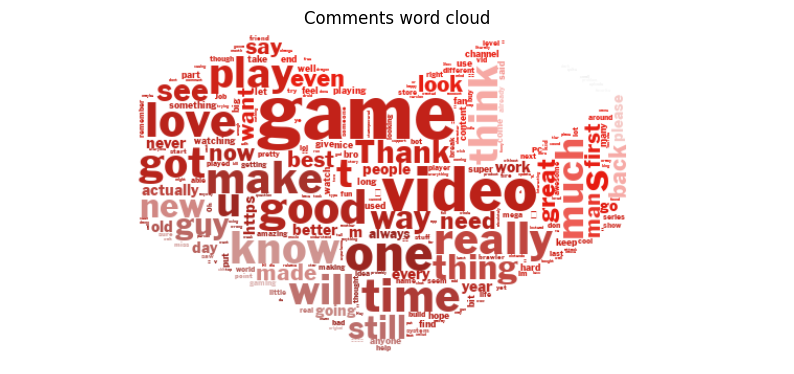

In [19]:
comments_wc = WordCloud(background_color= "white", max_words= 300, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf',
               collocations=False)

image_colors = ImageColorGenerator(np.array(coloring))
comments_wc.generate(comments)
comments_wc = comments_wc.recolor(color_func= image_colors)

comments_svg = comments_wc.to_svg(embed_font=True)

# Save the SVG code to a file
with open("../plots/comments_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(comments_svg)
    
fig, ax = plt.subplots(1)

ax.imshow(comments_wc, interpolation="bilinear")
ax.set_axis_off()

plt.title("Comments word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/comments_word_cloud.png")
plt.show()

Now we will make a word cloud for **video titles data**

In [20]:
popular_emojis = ["😊", "😍", "😘", "😜", "😝", "😂", "😭", "😡", "😠", "😩", "😫", "😞", "😟", "😢", "😥", "😰", "😱",
                       "😳", "😷", "👍", "👎", "👌", "👏", "🙌", "👋", "💪", "🙏", "❤️", "💔", "💕", "💖", "💘", "💙", "💚",
                       "💛", "💜", "💯", "🔥", "🌟", "✨", "⭐", "🌈", "🌺", "🍕", "🍔", "🍟", "🍦", "🍭", "🍩", "🍪", "🍺",
                       "🍻", "🍷", "🍸", "🎂", "🎁", "🎉", "🎊", "🎈", "🎵", "🎶", "🎼", "🎧", "🎤", "🎸", "🎹", "🎺", "🎷",
                       "🎻", "🎬", "🎥", "🎦", "📷", "📹", "📺", "📻", "💻", "📱", "💡", "🔑", "🔨", "🔥", "💰", "💳", "💼",
                       "📅", "📆", "📈", "📉", "📊", "📋", "📎", "📏", "📐", "🔒", "🔓", "🔍", "🔎", "🚀", "🚑", "🚒", "🚓",
                       "🚕", "🚗", "🚙", "🚚", "🚢", "🚤", "🚲", "🚶", "🚶‍♀️", "🏃", "🏃‍♀️", "⚽", "🏀", "🏈", "🎾", "🏐", "🏉",
                       "🎱", "🏓", "🏸", "🥊", "🥋", "🎮", "🕹️", "🎲", "🃏"]


for emoji in popular_emojis:
    stopwords.add(emoji)
    
titels = ''.join(
    temp_comments_df["title"][temp_comments_df["language"] == "English"].values.flatten())

'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


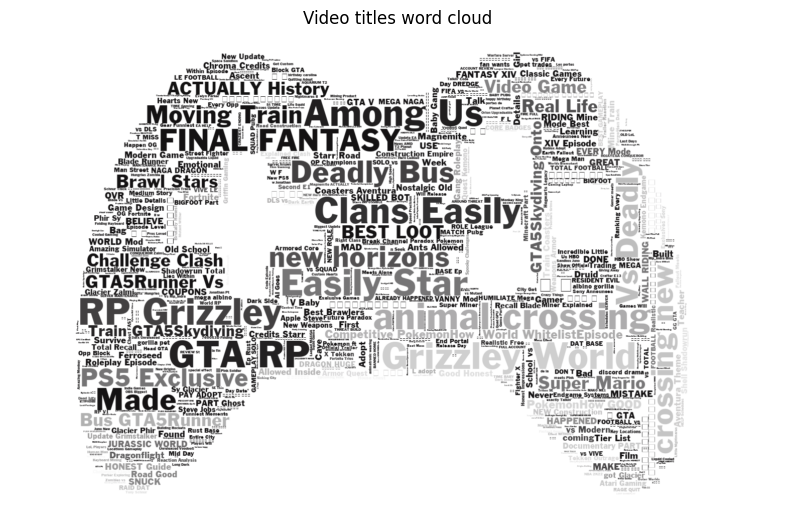

In [21]:
coloring = np.array(Image.open("../imgs/joystick.png"))

titels_wc = WordCloud(background_color= "white", max_words= 2000, mask= coloring,
               stopwords= stopwords, max_font_size= 80, random_state= 42,
               font_path= '../Data analysis/assets/fonts/FranklinGothic.ttf')

titels_wc.generate(titels)
image_colors = ImageColorGenerator(np.array(coloring))
titels_wc = titels_wc.recolor(color_func= image_colors)


fig, ax = plt.subplots(1)

ax.imshow(titels_wc, interpolation= "bilinear")
ax.set_axis_off()

titels_svg = titels_wc.to_svg(embed_font=True)

with open("../plots/videos_titels_word_cloud.svg", "w", encoding="utf-8") as f:
    f.write(titels_svg)

plt.title("Video titles word cloud")
fig.set_size_inches(10, 8)
plt.savefig("../plots/videos_titels_word_cloud.png")
plt.show()

In [22]:
del temp_comments_df

## <center><strong><span style = "color: red">NLP</span> preprocessing

In [ ]:
from nltk.corpus import stopwords
# nltk.download()

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('stopwords-hi')
nltk.download('stopwords-ar')
nltk.download('averaged_perceptron_tagger')


en_stopwords = set(stopwords.words('english')) 
ar_stopwords = set(stopwords.words('arabic')) 
# hi_stopwords = set(stopwords.words('hindi')) 

all_stopwords = en_stopwords.union(ar_stopwords)

#### *Part-of-speech (POS) Tagging*

In [ ]:
# Removing stop words

def stopwords_dropper(words: list, stopwords: set) -> list:
    
    # Removing stop words from unalphabetical chars
    filtered_words = [re.sub(r"[\W_]", "", word) for word in words
                      if not word in stopwords]
    
    filtered_words = list(filter(lambda item: item != "", filtered_words))
    return  filtered_words


for col in TEXT_COLUMNS:
    df[f"{col}_tokens"] = df[col].apply(lambda text: nltk.word_tokenize(text.lower()))
    df[f"{col}_tokens"] = df[f"{col}_tokens"].apply(lambda text: stopwords_dropper(text,
                                                                     all_stopwords))

df["title_tokens"]

In [25]:
for col in TEXT_COLUMNS:
    df[f"{col}_pos_tags"] = df[f"{col}_tokens"].apply(lambda words: nltk.pos_tag(words))
    
df["about_pos_tags"]

1746     [(hi, NN), (guys, NNS), (welcome, VBP), (new, ...
11337    [(aary, JJ), (baba, NN), (isko, NN), (mat, NN)...
18736    [(chào, NN), (mừng, NN), (đã, NNP), (đến, NNP)...
1883     [(channel, NNS), (dedicated, VBD), (summoners,...
12363    [(dan, NN), (allen, VBZ), (gaming, VBG), (s, J...
                               ...                        
9824     [(il, NN), (progetto, NN), (fius, JJ), (gamer,...
2113                            [(play, NN), (games, NNS)]
9643     [(beto, NN), (robin, NN), (hood, NN), (e, NN),...
1578     [(тук, JJ), (играем, NNP), (игри, NNP), (всяка...
15214    [(classic, JJ), (gaming, VBG), (quarterly, JJ)...
Name: about_pos_tags, Length: 2000, dtype: object

#### *Lemmatization and dropping duplicated words*

In [26]:
def get_wordnet_pos(treebank_tag: str) -> str:
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

In [27]:
lemmatizer = WordNetLemmatizer()
lemmatized_words = []
lemmatized_words_group = []

for col in TEXT_COLUMNS:
    for index, row in df.iterrows():
        for token, pos_tag in zip(row[f"{col}_tokens"], row[f"{col}_pos_tags"]):

            wordnet_pos = get_wordnet_pos(pos_tag[1])
            lemmatized_words_group.append(lemmatizer.lemmatize(token, pos= wordnet_pos))
            lemmatized_words_group = list(set(lemmatized_words_group)) # Dropping duplicates


        lemmatized_words.append(lemmatized_words_group)
        lemmatized_words_group = [] # clearing this list
    
    df[f"{col}_tokens"] = lemmatized_words
    lemmatized_words = []

In [28]:
df["channelTitle_tokens"][:5]

1746     [gaming, carlaylee, hd]
11337               [niyo, game]
18736         [longhunter, game]
1883           [xennial, gaming]
12363         [dan, game, allen]
Name: channelTitle_tokens, dtype: object

#### *One hot encoding*

In [29]:
df["language"] = df["language"].astype("category").cat.codes
df["definition"] = df["definition"].astype("category").cat.codes
df["country"] = df["country"].astype("category").cat.codes

cat_cols = ["country", "language", "definition"] # sentimints

# cat_df = df[cat_cols]
# df = df.drop(cat_cols, axis= 1)

# cat_df = pd.get_dummies(cat_df,)
# df = pd.concat([df, cat_df], axis = 1)

# cat_cols = [*cat_df.columns]


df["cat_view_count"] = df["cat_view_count"].replace({"from 1 to 3,000": 1, "from 3,000 to 10,000": 2,
                                                     "from 10,000 to 50,000": 3, "from 50,000 to 100,000": 4,
                                                     "from 100,000 to 300,000": 5, "more than 300,000": 6})

df["cat_like_count"] = df["cat_like_count"].replace({"from 1 to 1,000": 1, "from 1,000 to 5,000": 2,
                                                     "from 5,000 to 10,000": 3, "from 10,000 to 50,000": 4,
                                                     "from 50,000 to 150,000": 5, "more than 150,000": 6})

df["cat_comment_count"] = df["cat_comment_count"].replace({"from 1 to 75": 1, "from 75 to 150": 2,
                                                           "from 150 to 200": 3, "from 200 to 400": 4,
                                                           "from 400 to 600": 5, "more than 600": 6})

#### *Creating date features*

In [56]:
display(df[["date", "publishedAt"]][:5])
display(df[["date", "publishedAt"]].dtypes)

,date,publishedAt
1746,2017-05-24 00:00:00,2022-05-08 20:39:47+00:00
11337,2022-07-28 00:00:00,2023-01-12 06:57:31+00:00
18736,2017-05-26 00:00:00,2022-11-23 12:04:43+00:00
1883,2019-10-18 00:00:00,2022-10-12 06:28:55+00:00
12363,2014-02-01 00:00:00,2023-03-27 16:51:03+00:00


date           object
publishedAt    object
dtype: object

In [61]:
import pytz

today = datetime.utcnow().strftime("%Y-%m-%d")
today = datetime.strptime(today, "%Y-%m-%d")

channel_age = today - pd.to_datetime(df["date"])
df["channel_age_days"] = channel_age.dt.days.astype(int)

video_age = today - pd.to_datetime(df["publishedAt"]).dt.tz_localize(None)
df["video_age_days"] = video_age.dt.days.astype(np.uint16)

In [63]:
display(df[["channel_age_days", "video_age_days"]][:5])

,channel_age_days,video_age_days
1746,2188,377
11337,297,128
18736,2186,178
1883,1311,220
12363,3396,54


## <center>**Extracting manual text features**

## <center><strong><span style = "color: red">Models</span> training

#### *Preparing training & testing data*

In [27]:
# Changing dtypes of some colums:hh
df = df.astype({"total_views": np.uint64, "video_count": np.uint16,
                "duration_in_minutes": np.float32, "date": "datetime64[ns]",
                "publishedAt": "datetime64[ns]"})


# Those are just temporary text columns not the main one.
text_cols = ["tags", "about_tokens", "title_tokens",
             "channelTitle_tokens", "description_tokens"]

features_to_drop = ["viewCount",
                    "likeCount",
                    "commentCount"]

numeric_cols = [e for e in [*df.select_dtypes(NUMERICS).columns] if e not in features_to_drop]

target_cols = ["cat_view_count", "cat_like_count", "cat_comment_count"]

date_cols = ["date", "publishedAt"]



X = df[numeric_cols + cat_cols + date_cols + text_cols]
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1/5)

print(f"The shape of the X train data is: {X_train.shape}")
print(f"The shape of the X test data is: {X_test.shape}")
print(f"The shape of the y train data is: {y_train.shape}")
print(f"The shape of the y test data is: {y_test.shape}")

del X, y

The shape of the X train data is: (1600, 20)
The shape of the X test data is: (400, 20)
The shape of the y train data is: (1600, 3)
The shape of the y test data is: (400, 3)


Now we need to save the **features** and **targets** **labels flow** so we understand the inputs and outputs for the model.<br>

In [28]:
# X_trainX_train.columns
X_train_labels = {index: value for index, value in enumerate(X_train.columns)}
X_test_labels = {index: value for index, value in enumerate(X_test.columns)}

y_train_labels = {index: value for index, value in enumerate(y_train.columns)}
y_test_labels = {index: value for index, value in enumerate(y_test.columns)}

#### *preprocessing*

https://towardsdatascience.com/how-to-combine-textual-and-numerical-features-for-machine-learning-in-python-dc1526ca94d9

In [29]:
text_cols

['tags',
 'about_tokens',
 'title_tokens',
 'channelTitle_tokens',
 'description_tokens']

In [30]:
for X in X_train, X_test:
    
    for col in X[text_cols].columns:
        X[col] = X[col].astype(str)
        
    X["stacked_text"] = X[text_cols].agg(', '.join, axis=1).astype(str)
    X["stacked_text"] = X["stacked_text"].str.replace("[", "")
    X["stacked_text"] = X["stacked_text"].str.replace("]", "")

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\31253900.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\31253900.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("]", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\31253900.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\User

In [31]:
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
vectorizer = CountVectorizer()

for X in X_train, X_test:
            
    X["stacked_text"] = X[text_cols].agg(', '.join, axis=1).astype(str)
    X["stacked_text"] = X["stacked_text"].str.replace("[", "")
    X["stacked_text"] = X["stacked_text"].str.replace("]", "")
    
    numeric_cols_arr = scaler.fit_transform(X[numeric_cols])
    cat_cols_arr = X[cat_cols].to_numpy()
    text_col_arr = vectorizer.fit_transform(X["stacked_text"]).mean(axis=1)
    
    
    if X.shape == X_train.shape:
        
        X_train = np.asarray(np.hstack((numeric_cols_arr,
                    cat_cols_arr, text_col_arr)))
        
    elif X.shape == X_test.shape:
        
        X_test = np.asarray(np.hstack((numeric_cols_arr,
                            cat_cols_arr, text_col_arr)))
        
    
        
y_test = y_test.to_numpy().astype(int)
y_train = y_train.to_numpy().astype(int)

C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\2815132920.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\2815132920.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("]", "")
C:\Users\FreeComp\AppData\Local\Temp\ipykernel_15236\2815132920.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X["stacked_text"] = X["stacked_text"].str.replace("[", "")
C

In [32]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.370449,-0.295109,-0.331785,-0.175105,-0.428601,-0.347021,-0.713836,-0.395192,-0.897558,-1.022378,35.0,34.0,0.0,0.003888
1,2.436255,-0.322886,-0.378197,-0.351223,0.905565,1.102674,-0.624870,-0.079250,-0.672817,-0.197393,39.0,31.0,0.0,0.006090
2,-0.367568,-0.290639,-0.356213,-0.570707,-0.428601,-0.347021,-0.713836,0.560531,0.450886,1.434642,46.0,10.0,0.0,0.006330
3,-0.425820,-0.265417,-0.354078,-0.436184,-0.428601,-0.347021,-1.203145,0.377736,-0.672817,1.348557,17.0,10.0,0.0,0.007431
4,-0.356044,-0.126853,-0.270206,-0.260951,2.239730,1.102674,-0.180044,-0.354571,-0.672817,-0.982923,46.0,10.0,0.0,0.001755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1.845635,-0.343172,-0.400498,0.094825,-0.428601,-0.347021,-1.514524,0.222022,-0.672817,1.800505,16.0,12.0,0.0,0.005883
1596,-0.514154,-0.323301,-0.382427,-0.238826,-0.428601,1.102674,-0.046596,-0.740470,-1.347039,-1.036726,18.0,13.0,0.0,0.004232
1597,-0.319310,-0.134196,-0.297557,-0.765410,-0.428601,-0.347021,-1.647972,-0.149209,0.450886,-0.789230,46.0,10.0,0.0,0.002512
1598,0.667997,0.088974,-0.055090,0.258553,-0.428601,-0.347021,-1.114180,-0.763038,-0.448077,0.763894,23.0,16.0,0.0,0.002340


In [33]:
print(f" The shape of X train is: {X_train.shape}\n" + \
      f" The shape of X test is: {X_test.shape}\n" + \
      f" The shape of y train is: {y_train.shape}\n" + \
      f" The shape of y test is: {y_test.shape}.")

 The shape of X train is: (1600, 14)
 The shape of X test is: (400, 14)
 The shape of y train is: (1600, 3)
 The shape of y test is: (400, 3).


In [34]:
# We should scale y_train & y_test between 0 and 5 so
# all the models works the best

y_train -= 1
y_test -= 1

#### *Choosing the models we will test*

Now we will try to test deffrint models to find the best one:
- Classfier models
- Regression models
- Ordinal Regression models
- Deep learning models <!--<sub>*(not in this notebook)</sub>-->

In [35]:
# We should create our custom confusion matrix function becuase of the multiclass
# labels that aren't supported in sk-learn and plot the confusion matrix with 
# matplotlib

def plot_confusion_matrix(y_true: np.array, y_pred: np.array,
                          model_name: str = "", cmap= "light:red"):
    
    num_of_targets = y_true.shape[1]
    fig, axes = plt.subplots(1, num_of_targets)
    
    for i in range(num_of_targets):
        
        plot_title = [*df[target_cols].columns.str.slice(
            4).str.replace("_", " ").str.title() + " Confusion Matrix"][i]
        
        mat = confusion_matrix(y_true[:, i], y_pred[:, i])
        sns.heatmap(mat, linewidth=.5, ax= axes[i],
                    cmap= sns.color_palette(cmap, as_cmap=True))
        
        axes[i].set_title(plot_title)
        
    fig.set_size_inches(14, 3.5)
    fig.suptitle(f"{model_name} Confusion Matrices")
    
    plt.subplots_adjust(top = .8)
    plt.show()

##### **Classification**:

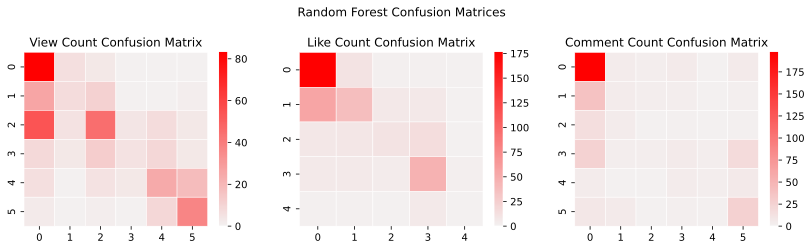

In [36]:
## Random Forests
rf = RandomForestClassifier(n_estimators= 300, max_depth= 50, n_jobs= -1)
rf_classifier = MultiOutputClassifier(rf, n_jobs= -1)
rf_classifier.fit(X_train, y_train)


y_pred = rf_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Random Forest")

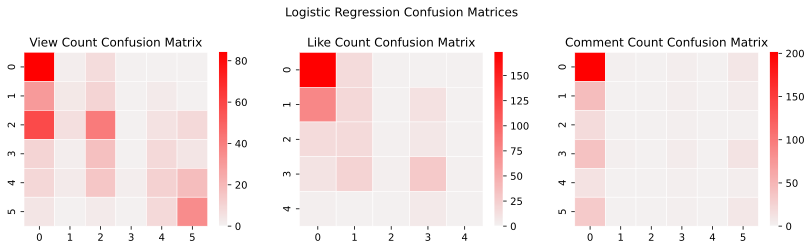

In [37]:
## Logistic Regression
logistic  = LogisticRegression(multi_class= "multinomial",
                              max_iter= 200, n_jobs= -1)

logistic_classifier = MultiOutputClassifier(logistic, n_jobs= -1)
logistic_classifier.fit(X_train, y_train)

y_pred = logistic_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")

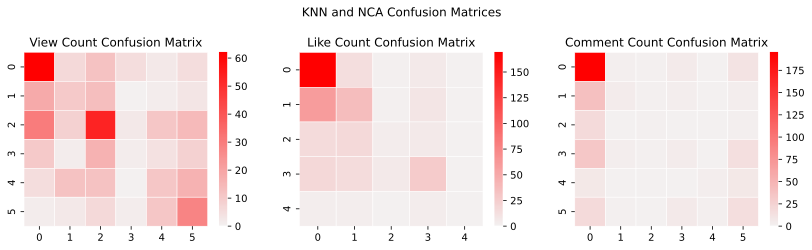

In [38]:
## NCA & KNN
nca = NeighborhoodComponentsAnalysis(n_components= 10)
knn = KNeighborsClassifier(n_neighbors= 25, algorithm= "kd_tree")

pipe = Pipeline([("nca", nca), ("knn", knn)])

knn_classifier = MultiOutputClassifier(pipe, n_jobs= -1)
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)
plot_confusion_matrix(y_test, y_pred, "KNN and NCA")

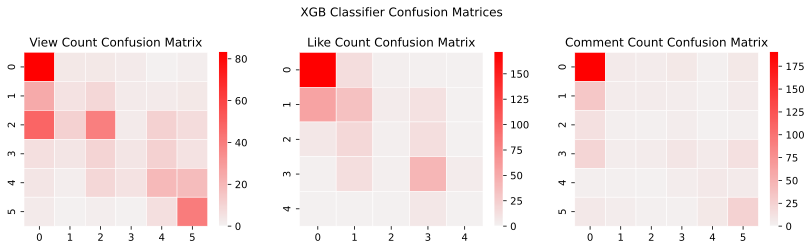

In [39]:
## XGB Classifier
xgb = xgboost.XGBClassifier(
    n_estimators= 150,
    max_depth= 7,
    learning_rate=0.01)

xgb_classifier = MultiOutputRegressor(xgb, n_jobs= -1)
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

plot_confusion_matrix(y_test, y_pred, "XGB Classifier", "light:red")

##### **Regression**

*We will round the results so it work as a classification model.

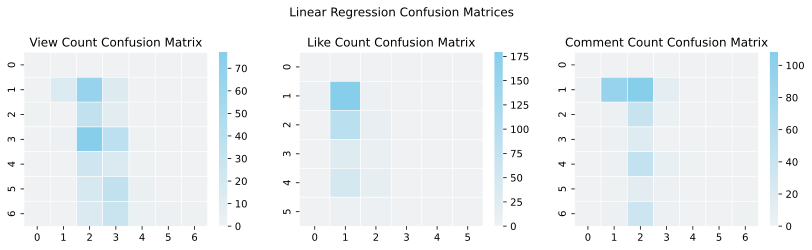

In [40]:
## Linear Regression
linear = LinearRegression()
linear_regressor = MultiOutputRegressor(linear, n_jobs= -1)
linear_regressor.fit(X_train, y_train - 1)

y_pred = linear_regressor.predict(X_test)

# Fixed y pred
y_pred *= (5 / y_pred.max())
y_pred = y_pred.round().astype('int')

plot_confusion_matrix(y_test, y_pred, "Linear Regression", "light:skyblue")

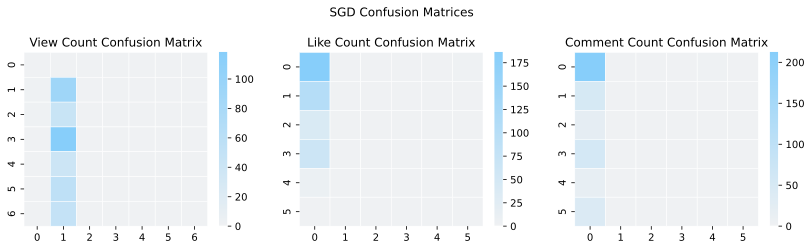

In [50]:
## SGD classifier
sgd = SGDRegressor()
sgd_regressor = MultiOutputRegressor(sgd, n_jobs= -1)
sgd_regressor.fit(X_train, y_train)

y_pred = sgd_regressor.predict(X_test)

y_pred *= (5 / y_pred.max())
y_pred = y_pred.round().astype('int')

plot_confusion_matrix(y_test, y_pred, "SGD", "light:lightskyblue")

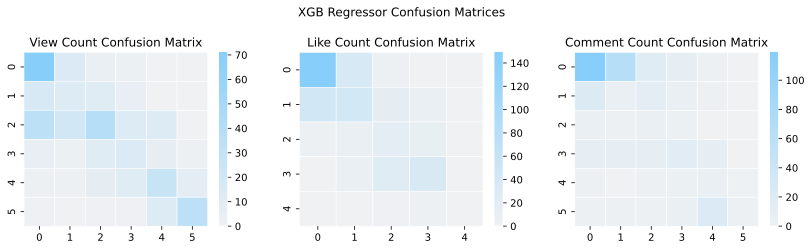

In [51]:
## XGB Regressor
xgb = xgboost.XGBRegressor(
    n_estimators= 150,
    max_depth= 7,
    learning_rate=0.01)

xgb_regressor = MultiOutputRegressor(xgb, n_jobs= -1)
xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

y_pred *= (5 / y_pred.max())
y_pred = y_pred.round().astype('int')

plot_confusion_matrix(y_test, y_pred, "XGB Regressor", "light:lightskyblue")

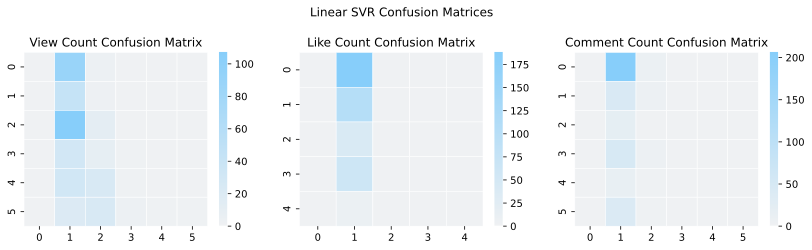

In [52]:
## Linear SVR
svr = LinearSVR(tol= 1e-3,
                max_iter= 2_000,
                epsilon= 2)

svr_regressor = MultiOutputRegressor(svr, n_jobs= -1)
svr_regressor.fit(X_train, y_train)

y_pred = svr_regressor.predict(X_test)

y_pred *= (5 / y_pred.max())
y_pred = y_pred.round().astype('int')

plot_confusion_matrix(y_test, y_pred, "Linear SVR", "light:lightskyblue")

##### **Deep leanring**

In [171]:
## Deep Learning Regression
regression_nn = keras.Sequential()

regression_nn.add(keras.layers.Dense(units= 14, activation= "sigmoid",
                             input_shape= (14,))) # Input layer

regression_nn.add(keras.layers.Dropout(0.1))

regression_nn.add(keras.layers.Dense(units= 32,
                             activation= "softplus")) # Hidden layer

regression_nn.add(keras.layers.Dropout(0.2))

regression_nn.add(keras.layers.Dense(units= 32,
                             activation= "softmax")) # Hidden layer

regression_nn.add(keras.layers.Dropout(0.15))

regression_nn.add(keras.layers.Dense(units= 3,
                             activation= None)) # Output layer


regression_nn.compile(loss= 'mean_absolute_error',
              optimizer= "adam",
              metrics= ['accuracy'])

regression_nn.fit(X_train, y_train,
          epochs= 200, batch_size= 9)

Epoch 1/200
178/178 [==============================] - 1s 2ms/step - loss: 1.5215 - accuracy: 0.8913
Epoch 2/200
178/178 [==============================] - 0s 2ms/step - loss: 1.4388 - accuracy: 0.9144
Epoch 3/200
178/178 [==============================] - 0s 2ms/step - loss: 1.4183 - accuracy: 0.9144
Epoch 4/200
178/178 [==============================] - 0s 2ms/step - loss: 1.3754 - accuracy: 0.9144
Epoch 5/200
178/178 [==============================] - 0s 2ms/step - loss: 1.3551 - accuracy: 0.9144
Epoch 6/200
178/178 [==============================] - 0s 2ms/step - loss: 1.3436 - accuracy: 0.9144
Epoch 7/200
178/178 [==============================] - 0s 2ms/step - loss: 1.3430 - accuracy: 0.9144
Epoch 8/200
178/178 [==============================] - 0s 2ms/step - loss: 1.3232 - accuracy: 0.9144
Epoch 9/200
178/178 [==============================] - 0s 2ms/step - loss: 1.2872 - accuracy: 0.9144
Epoch 10/200
178/178 [==============================] - 0s 2ms/step - loss: 1.2504 - accura

13/13 [==============================] - 0s 0s/step


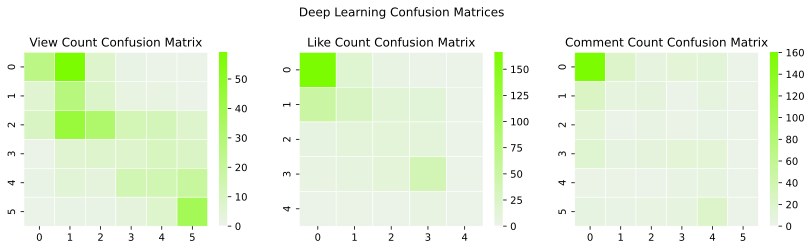

In [172]:
y_pred = regression_nn.predict(X_test)

y_pred *= (5 / y_pred.max())
y_pred = y_pred.round().astype('int')

plot_confusion_matrix(y_test, y_pred, "Deep Learning", "light:lawngreen")

#### *More tests for the models performance*

In [183]:
models = {rf_classifier: "Random Forest", logistic_classifier: "Logistic regressor",
          xgb_classifier: "XGB Classifier", linear_regressor: "Linear regressor",
          knn_classifier: "KNN & NCA", svr_regressor: "SVR regressor",
          sgd_regressor: "SGD regressor", regression_nn: "NN regressor"}

##### **Creating models measures**

Firstly we will use `cohen kappa` to measure the performance of our model becuase it works the best with our case and here's<br>
it's theory: $$k \equiv \frac{p_0 - p_e}{1 - p_e} = 1 - \frac{1-p_e}{1-p_0}$$
Where: $p_e$ is the hypothetical probability of chance agreement<br> 
$~~~~~~~~~~~p_0$ is is the relative observed agreement among raters

Also: $k$ **can't** be more than $1$ or less than $-1$

In [181]:
def cohen_kappa(y_true, y_pred):
    num_outputs = y_true.shape[1]
    weighted_kappas = []

    for i in range(num_outputs):
        true_output = y_true[:, i]
        pred_output = y_pred[:, i]
        kappa = cohen_kappa_score(true_output, pred_output, weights='quadratic')
        weighted_kappas.append(kappa)

    average_kappa = sum(weighted_kappas) / len(weighted_kappas)
    return average_kappa

Now we will use **Mean absolute error** `MAD` to mesure the performance and here's it's theory:<br>
${\displaystyle \mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}}$<br><br>
**Where:** $y_i$ is the prediction and $x_{i}$ the true value

In [175]:
def MAE(y_true, y_pred):
    
    mae = np.mean(np.abs(np.array(y_true) - np.array(y_pred)))
    return mae

Also we will use **Root Mean Squared Error** `RMSE`

In [177]:
def RMSE(y_true, y_pred):
    
    mse = np.mean((np.array(y_true) - np.array(y_pred))**2)
    rmse = np.sqrt(mse)
    
    return rmse

And at last but not least we will use the coefficient of determination aka Sklearn's $R^2$ score and here's it's theroy:<br>
${\displaystyle R^{2}=1-{SS_{\rm {res}} \over SS_{\rm {tot}}}}$<br><br>
*Where:*<br>
${\displaystyle \overline{y}=\mu}$<br>
${\displaystyle SS_{\text{tot}}=\sum _{i}(y_{i}-{\bar {y}})^{2}}$ (total sum of squares) <br>
${\displaystyle SS_{\text{res}}=\sum _{i}(y_{i}-f_{i})^{2}=\sum _{i}e_{i}^{2}\,}$ (residual sum of squares)

In [ ]:
r2_score(y_test, y_pred,
        multioutput= 'uniform_average',
        force_finite= False)

##### **Visualizing models performance**

In [228]:
def model_report(y_true, y_pred):

    rmse = RMSE(y_test, y_pred)
    mae = MAE(y_test, y_pred)
    kappa = cohen_kappa(y_test, y_pred)
    r2 = r2_score(y_test, y_pred,
                  multioutput= 'uniform_average',
                  force_finite= False)

    print(" | RSME: {:.2f}            |\n".format(rmse),
          "| MAE: {:.2f}             |\n".format(mae) ,
          "| R^2 score: {:.2f}       |\n".format(r2),
          "| Kappa: {:.2f}           |".format(kappa))

In [231]:
print("*"* 50, "ML models testing", "*" * 50, "\n")

for model, model_name in zip(models.keys(), models.values()):
    
    
    y_pred = model.predict(X_test).astype('int')
    
    y_pred = (5 / y_pred.max()) * y_pred
    y_pred = y_pred.round().astype('int')
    
    print(f"{model_name}: ")
    
    print("=" * 27)
    model_report(y_test, y_pred)
    print("=" * 27 + "\n")

************************************************** ML models testing ************************************************** 

Random Forest: 
 | RSME: 1.28            |
 | MAE: 0.71             |
 | R^2 score: 0.36       |
 | Kappa: 0.71           |

Logistic regressor: 
 | RSME: 1.64            |
 | MAE: 0.98             |
 | R^2 score: -0.05       |
 | Kappa: 0.49           |

XGB Classifier: 
 | RSME: 1.32            |
 | MAE: 0.76             |
 | R^2 score: 0.32       |
 | Kappa: 0.70           |

Linear regressor: 
 | RSME: 1.70            |
 | MAE: 1.20             |
 | R^2 score: -0.27       |
 | Kappa: 0.15           |

KNN & NCA: 
 | RSME: 1.63            |
 | MAE: 0.98             |
 | R^2 score: -0.07       |
 | Kappa: 0.48           |

SVR regressor: 
 | RSME: 1.65            |
 | MAE: 1.30             |
 | R^2 score: -0.12       |
 | Kappa: 0.04           |

SGD regressor: 
 | RSME: 9.09            |
 | MAE: 3.25             |
 | R^2 score: -38.51       |
 | Kappa: -0.04     

<Axes: >

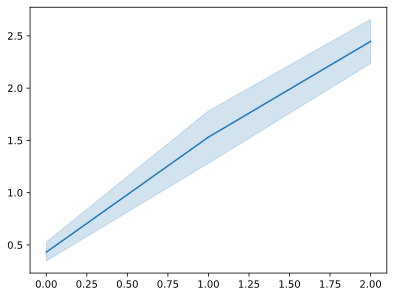

In [236]:
sns.lineplot(x= y_pred[:, 1], y= y_test[:, 1])

We can found that the `sk-learn` built-in accuracy score calculator is **not so accurate** as if we created a function that calculates<br>
the score **manually** and also create a function that plot the performance of each model then we choose the best from them to<br>
save & use in the Web app.

In [134]:
def calculate_weighted_kappa(y_true, y_pred):
    num_outputs = y_true.shape[1]
    weighted_kappas = []

    for i in range(num_outputs):
        true_output = y_true[:, i]
        pred_output = y_pred[:, i]
        kappa = cohen_kappa_score(true_output, pred_output, weights='quadratic')
        weighted_kappas.append(kappa)

    average_kappa = sum(weighted_kappas) / len(weighted_kappas)
    return average_kappa

# Ordinal regression
# normal regression

In [173]:
calculate_weighted_kappa(y_test, y_pred) # kappa score starts from -1

0.6562637255657551

In [174]:
r2_score(y_test, y_pred,
        multioutput= 'uniform_average',
        force_finite= False)

0.34436615991066377

Now

Weighted Average Rank Accuracy (WARA)

In [117]:
def model_report(y_true, y_pred):

    pre = precision_score(y_true, y_pred, pos_label=1, average='binary')
    rec = recall_score(y_true, y_pred, average= "micro")
    f1 = f1_score(y_true, y_pred, average= "micro")
  # loss = log_loss(y_true, y_pred, normalize= False)
    acc = accuracy_score(y_true, y_pred)

    print("| precision: {:4f}        |\n".format(pre) + \
          "| recall: {:4f}           |\n".format(rec) + \
          "| f1-score: {:4f}         |\n".format(f1) + \
          "| accuracy: {:4f}         |".format(acc))

In [ ]:
model_report(y_true, y_pred)